In [1]:
from pathlib import Path
from typing import NamedTuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import scipy

import scipy.fftpack as spfft
from sklearn.linear_model import Lasso

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

from PIL import Image

In [2]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved

In [3]:
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state, done_state):
        (terminated, truncated) = done_state
        done = terminated or truncated

        if terminated:
            self.qtable[new_state, :] = reward
            self.visits[new_state, :] += 1
                
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta

        self.qtable[state, action] = q_update
        self.visits[state, action] += 1
        # return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        # self.qtable = np.zeros((self.state_size, self.action_size))
        self.qtable = np.ones((self.state_size, self.action_size))*0.01
        self.visits = np.zeros((self.state_size, self.action_size))

In [4]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

In [5]:
def learn_qtable(env, learner, explorer, init_qtable, no_of_episodes_to_learn ):
    learner.qtable = init_qtable # Initalize the qtable
    state_action_distribution = np.zeros_like(learner.qtable)
    for episode in range(no_of_episodes_to_learn):
        env.reset(seed=params.seed)[0]  # Reset the environment
        step = 0
        done = False
         # initialize agent to random state that is not a HOLE
        while True:
            env.env.env.env.s = np.random.randint(0, params.state_size - 1)
            if env.desc.ravel()[env.env.env.env.s] != b'H':
                break
        state = env.env.env.env.s

        while not done:
            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.qtable
            )

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)
            
            """
            Reward schedule:
            - Reach goal: +1
            - Reach hole: -1
            - Reach frozen: 0
            """
            
            row = new_state//map_size
            col = new_state - row*map_size
            if env.desc[row, col] == b'H':
                reward = -1 
            done = terminated or truncated
            done_state = (terminated, truncated)

            learner.update(
                state, action, reward, new_state, done_state
            )
    
            # Our new state is state
            state = new_state

In [6]:
def eval_qtable(env, qtable, no_of_episodes):
    rewards = np.zeros(no_of_episodes)
    steps = np.zeros(no_of_episodes)
    for i in range(no_of_episodes):
        # Reset the environment
        env.reset(seed=params.seed)[0]  
        step = 0
        done = False
        total_rewards = 0
        
        # intialize state to random coordinate
        while True:
            env.env.env.env.s = np.random.randint(0, params.state_size - 1)
            if env.desc.ravel()[env.env.env.env.s] != b'H':
                break
        state = env.env.env.env.s
        while not done:
            # choose_action
            # if np.all(qtable[state, :]) == qtable.sum(axis=0)/:
            #     action = action_space.sample()
            # else:
            #     action = np.argmax(qtable[state, :])

            action = np.random.choice(np.flatnonzero(qtable[state, :] == qtable[state, :].max()))
                
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)
        
            """
            Reward schedule:
            - Reach goal: +1
            - Reach hole: -1
            - Reach frozen: 0
            """
            row = new_state//map_size
            col = new_state - row*map_size
            if env.desc[row, col] == b'H':
                reward = -1 
            done = terminated or truncated
        
            step += 1
            # Our new state is state
            state = new_state
            
        rewards[i] = reward
        steps[i] = step
    return rewards, steps         

In [7]:
def idct2(x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

In [8]:
def viz_qtable(qtable, description):
    no_of_states, no_of_actions = qtable.shape
    mapdim = int(np.sqrt(no_of_states))
    # https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
    fig, axes = plt.subplots(nrows=1, ncols=no_of_actions, figsize=(16, 4))
    cmap = matplotlib.colormaps['gray']
    # normalizer = matplotlib.colors.Normalize(vmin=-2, vmax=2)
    normalizer = matplotlib.colors.Normalize()
    im = matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap)
    
    for i,ax in enumerate(axes):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text(directions[i])
        im = ax.imshow(qtable[:,i].reshape(mapdim,mapdim),
                       cmap=cmap,
                       norm=normalizer)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.suptitle(description, fontsize=10)
    plt.show()

In [9]:
params = Params(
    total_episodes=1000,
    learning_rate=0.8,
    gamma=0.99,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=1,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("./renders/"),
)

In [10]:
map_size = 100
directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
# Set the seed
rng = np.random.default_rng(params.seed)

In [11]:
my_map = np.empty((map_size, map_size), dtype='S1')
# map_bmp = np.array(Image.open('100x100_block.bmp'))
map_bmp = np.array(Image.open(f'{map_size}x{map_size}_block.bmp'))

# initalize with all holes
my_map[:] = b'H'

# only True cells are frozen
my_map[map_bmp] = b'F'

# first cell is start
my_map[0][0] = b'S'

# last cell is goal
my_map[-1][-1] = b'G'

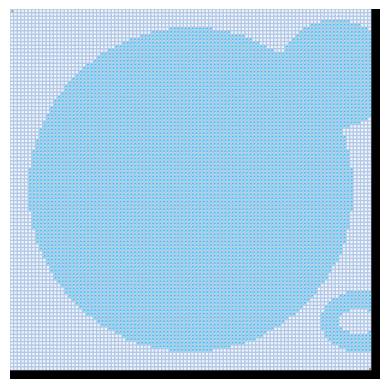

Map size: 100x100


In [12]:
env = gym.make(
        "FrozenLake-v1",
        max_episode_steps=150,
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=my_map,
    )
env.reset(seed=params.seed)[0]
plt.imshow(env.render())
plt.axis('off')
plt.show()

# update parameters
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)

env.action_space.seed(
    params.seed
)  # Set the seed to get reproducible results when sampling the action space

# create learner
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)

# create explorer
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

print(f"Map size: {map_size}x{map_size}")

In [13]:
no_of_episodes_to_eval = 100# map_size**2
no_of_episodes_to_learn = 500

no_of_cycles = 20

In [14]:
# reset q_table
learner.reset_qtable()
# evaluate initial q_table
rewards, _ = eval_qtable(env, learner.qtable, no_of_episodes_to_eval)
# initial performance
print(f"After {0*no_of_episodes_to_learn} episodes, the average reward is {np.mean(rewards)}")

After 0 episodes, the average reward is -0.56


In [15]:
# create dct matrix operator using kron (memory errors for large ny*nx)
ny, nx = learner.qtable.shape
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
lasso = Lasso(alpha=0.001, warm_start=True, random_state=True)

In [16]:
def cs_predict(learner):

    # Reconstruct qtable
    X = learner.qtable
    ny, nx = X.shape
    
    # extract small sample of signal
    sample_ratio = 0.5
    k = int(np.round(nx * ny * sample_ratio))
    
    state_action_distribution = learner.visits/np.sum(learner.visits)
    SAdist_sorted = np.sort(state_action_distribution.flatten())
    threshold_prob = SAdist_sorted[int(np.floor((1-sample_ratio)*len(SAdist_sorted)))]
    ri = np.where(state_action_distribution.flatten() > threshold_prob)[0]
    
    # ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
    b = X.T.flat[ri]
    b = (b-np.min(b))/(np.max(b)-np.min(b)) # normalize
    b = np.expand_dims(b, axis=1)
    # compression matrix @ transform matrix
    Ac = A[ri,:] # same as phi times kron
    
    lasso.fit(Ac, b)

    # Reconstruct qtable
    Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns
    # Get the reconstructed qtable
    Xa = idct2(Xat)

    return Xa

# def cs_predict(learner):
#     # Get the sensing matrix from state-action probability
#     state_action_distribution = learner.visits/np.sum(learner.visits)
#     # sensing_matrix = np.diagflat(state_action_distribution.flatten())
#     # use qvalue of states that have been visited most frequently
#     Bt = np.sort(state_action_distribution.flatten())
#     keep = 0.9
#     threshold_prob = Bt[int(np.floor((1-keep)*len(Bt)))]
#     indices = np.where(state_action_distribution.flatten() > threshold_prob)[0]
#     Ac = A[indices,:]
#     b = learner.qtable.flatten()[indices]

#     # Create optimization problem
#     lasso = Lasso(alpha=0.001)
#     lasso.fit(Ac, b)    
    
#     # Reconstruct qtable
#     Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns
#     # Get the reconstructed qtable
#     Xa = idct2(Xat)

#     return Xa

In [17]:
def plot_qtable_diff(original_qtable, predicted_qtable):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 4))
    ax = axes[0]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.plot(learner.qtable.flatten())
    ax.plot(predicted_qtable.flatten())
    ax = axes[1]
    ax.plot(learner.qtable.flatten()-predicted_qtable.flatten())

    plt.show()
    

In [ ]:
for i in range(no_of_cycles):
    # learn for no_of_episodes_to_learn
    learn_qtable(env, learner, explorer, learner.qtable, no_of_episodes_to_learn )
    
    # evaluate new q_table
    rewards, _ = eval_qtable(env, learner.qtable, no_of_episodes_to_eval)
    
    print("*"*10)
    print(f"After {(i+1)*no_of_episodes_to_learn} episodes, the average reward is {np.mean(rewards)}")

    # visualize q-table
    viz_qtable(learner.qtable, "Learnt Q-table")

    # populate qtable using compressed sensing
    predicted_qtable = cs_predict(learner)

    # visualize q-table
    viz_qtable(predicted_qtable, "Reconstructed Q-table")

    # visualize the difference
    plot_qtable_diff(learner.qtable, predicted_qtable)
    
    # update new qtable
#####################################
    # learner.qtable = predicted_qtable
#####################################

In [64]:
qtable = learner.qtable

In [66]:
frame = qtable[:,1].reshape(100,100)

(-0.5, 99.5, 99.5, -0.5)

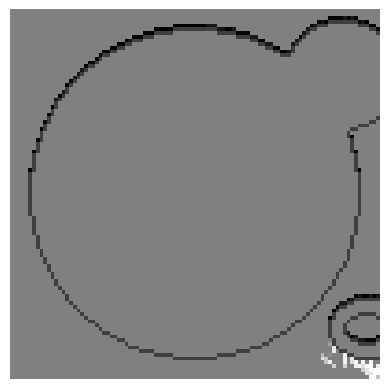

In [68]:
plt.figure()
plt.imshow(frame, cmap="gray")
plt.axis("off")

In [69]:
norm_frame = (frame - frame.min())/(frame.max() - frame.min())

In [71]:
norm_frame.max(), norm_frame.min()

(1.0, 0.0)

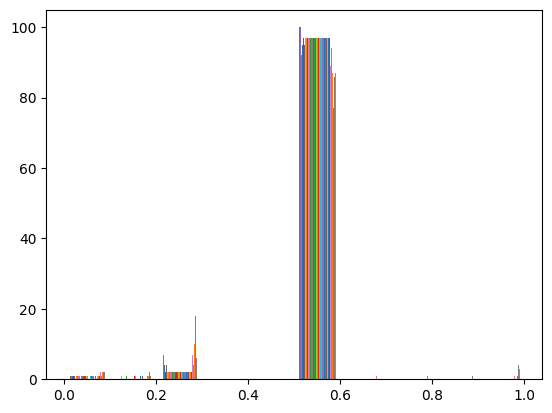

In [73]:
plt.hist(norm_frame);

In [103]:
norm_frame.mean()

0.4904992476355918

In [105]:
# Reconstruct qtable
X = norm_frame
ny, nx = X.shape

In [116]:
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
lasso = Lasso(alpha=0.0001, warm_start=True, random_state=True)

In [117]:
b = X.T.flat

In [125]:
ri = np.where(b > np.percentile(b, 90))[0]

In [126]:
# # extract small sample of signal
# sample_ratio = 0.5
# k = int(np.round(nx * ny * sample_ratio))

# state_action_distribution = learner.visits/np.sum(learner.visits)
# SAdist_sorted = np.sort(state_action_distribution.flatten())
# threshold_prob = SAdist_sorted[int(np.floor((1-sample_ratio)*len(SAdist_sorted)))]
# ri = np.where(state_action_distribution.flatten() > threshold_prob)[0]

In [127]:
# ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = b[ri]
# b = (b-np.min(b))/(np.max(b)-np.min(b)) # normalize
b = np.expand_dims(b, axis=1)
# compression matrix @ transform matrix
Ac = A[ri,:] # same as phi times kron

lasso.fit(Ac, b)

# Reconstruct qtable
Xat = np.array(lasso.coef_).reshape(nx, ny).T # stack columns
# Get the reconstructed qtable
Xa = idct2(Xat)

ValueError: Found array with dim 3. Lasso expected <= 2.

In [129]:
Xa.shape

(100, 100)

(-0.5, 99.5, 99.5, -0.5)

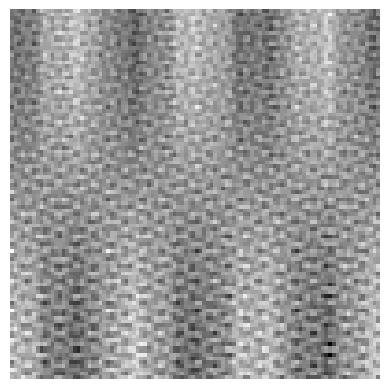

In [130]:
plt.figure()
plt.imshow(Xa, cmap="gray")
plt.axis("off")